In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import entropy
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

#load dataset
pd.set_option('display.max_columns', None)
df = pd.read_csv('dataset/incident_profile_95.csv')
df.columns.sort_values()

Index(['BEAT_OF_OCCURRENCE', 'CRASH_MONTH', 'CRASH_YEAR',
       'adverse_weather_crash_rate', 'avg_age', 'avg_crash_severity_score',
       'avg_lighting_severity', 'avg_responsibility_score',
       'avg_roadway_severity', 'avg_weather_severity',
       'combined_weather_road_severity', 'damage_cost_LB', 'damage_high',
       'damage_low', 'damage_medium', 'fatality_rate', 'injury_severity_score',
       'monthly_total_units', 'neo_patented_drivers', 'night_crash_rate',
       'num_towed_units_LB', 'pct_neo_patented_drivers', 'pct_senior_drivers',
       'road_defect_crash_rate', 'senior_drivers', 'severe_injury_rate',
       'speeding_influence', 'sum_category_motorcycle',
       'sum_category_off-road/specialized', 'sum_category_passenger vehicle',
       'sum_category_public transport', 'sum_category_truck/commercial',
       'sum_damage_category_high', 'sum_damage_category_low',
       'sum_damage_category_medium', 'sum_lighting_category_daylight',
       'sum_lighting_category_n

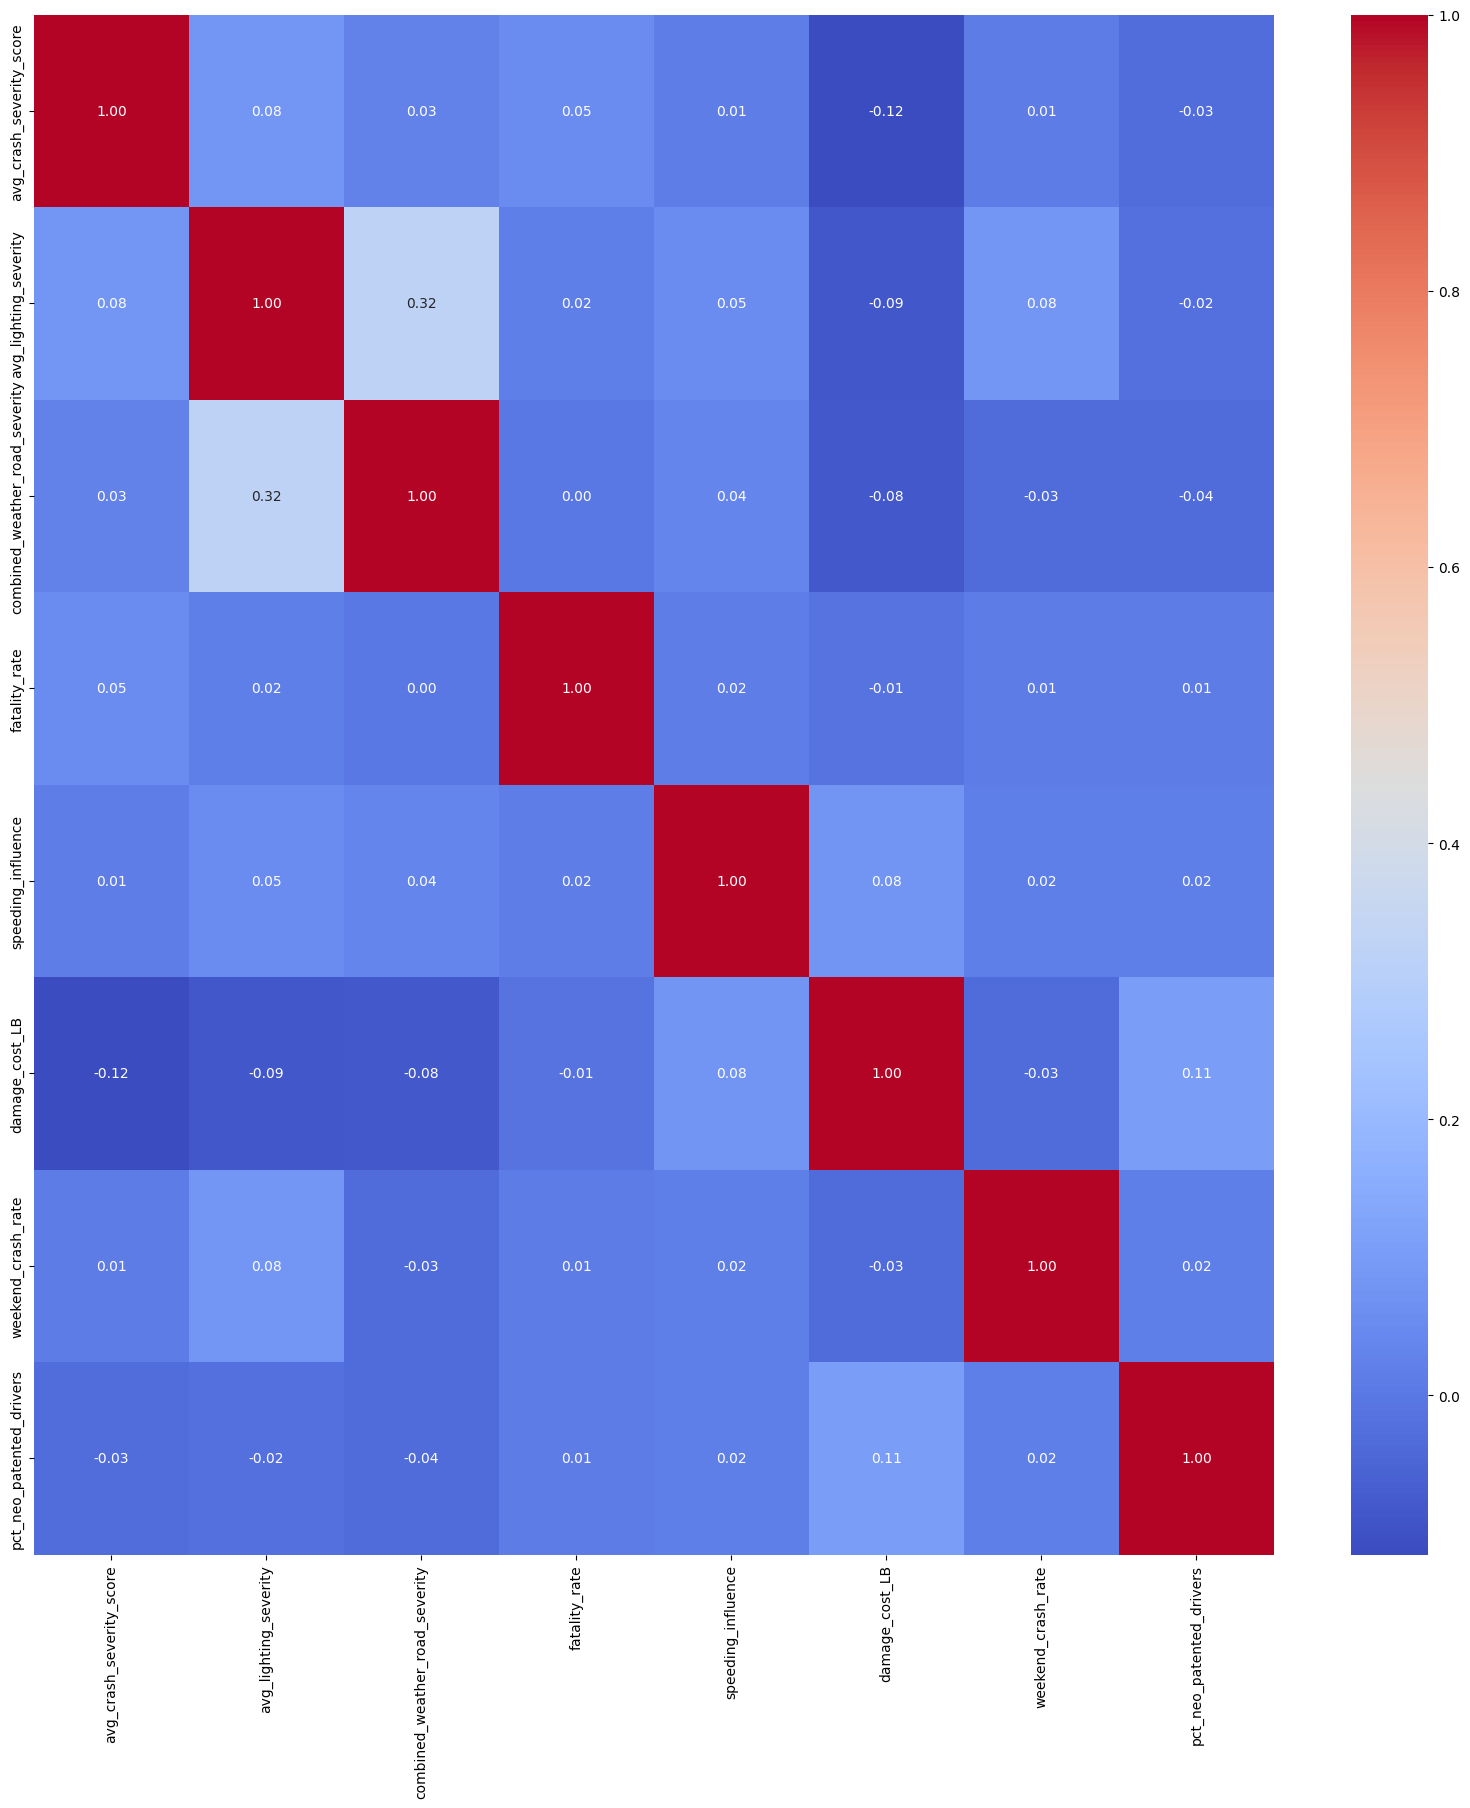

In [2]:
selected_features_OLD = ['avg_age', 'avg_crash_severity_score', 'avg_lighting_severity',
           'combined_weather_road_severity', 'fatality_rate', 'speeding_influence',
           'damage_cost_LB', 'weekend_crash_rate', 'pct_neo_patented_drivers']

selected_features = ['avg_crash_severity_score', 'avg_lighting_severity',
           'combined_weather_road_severity', 'fatality_rate', 'speeding_influence',
           'damage_cost_LB', 'weekend_crash_rate', 'pct_neo_patented_drivers']

plt.figure(figsize=(20, 20))
sns.heatmap(df[selected_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

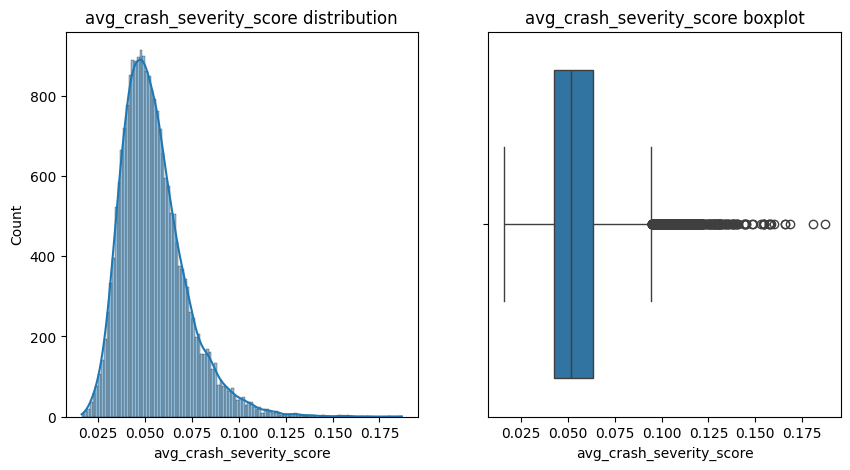

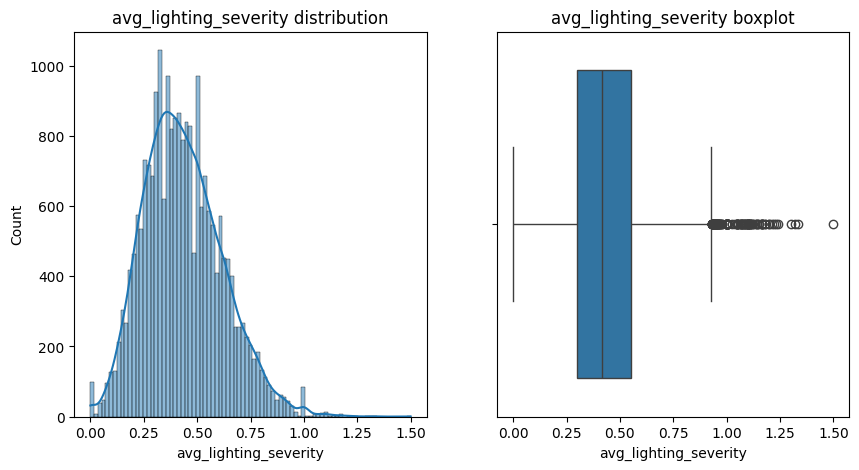

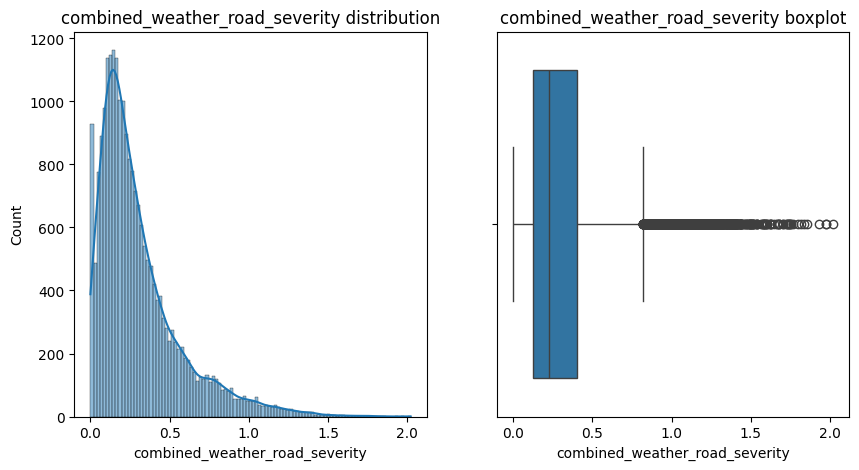

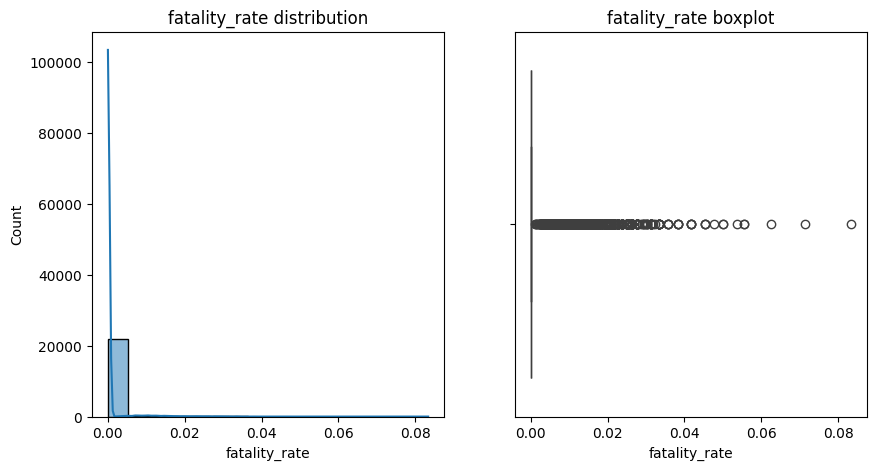

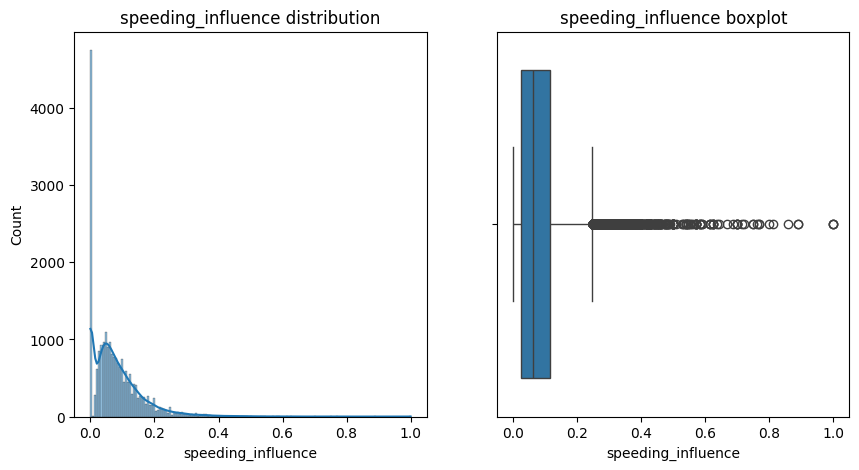

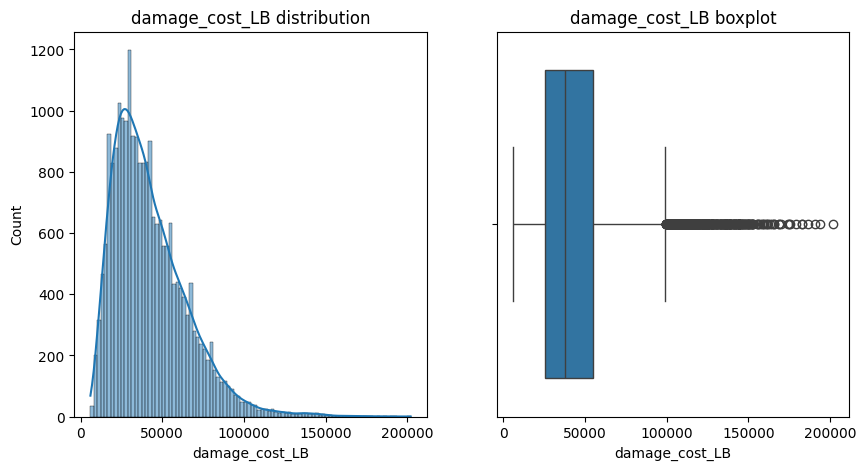

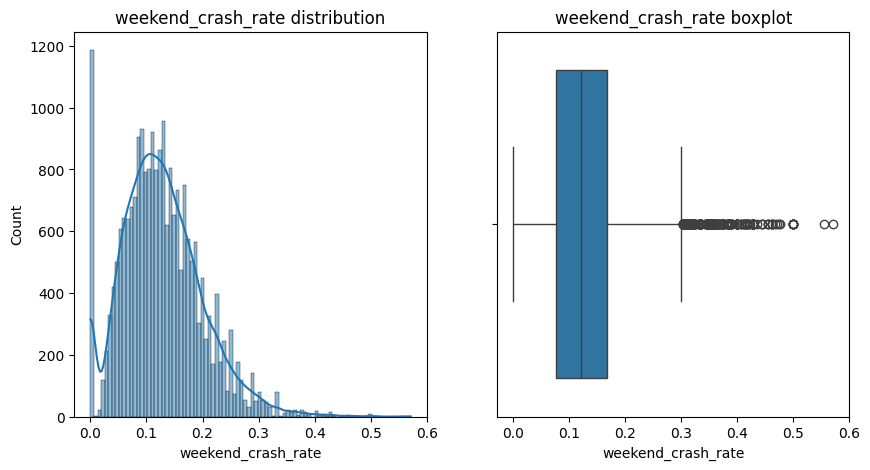

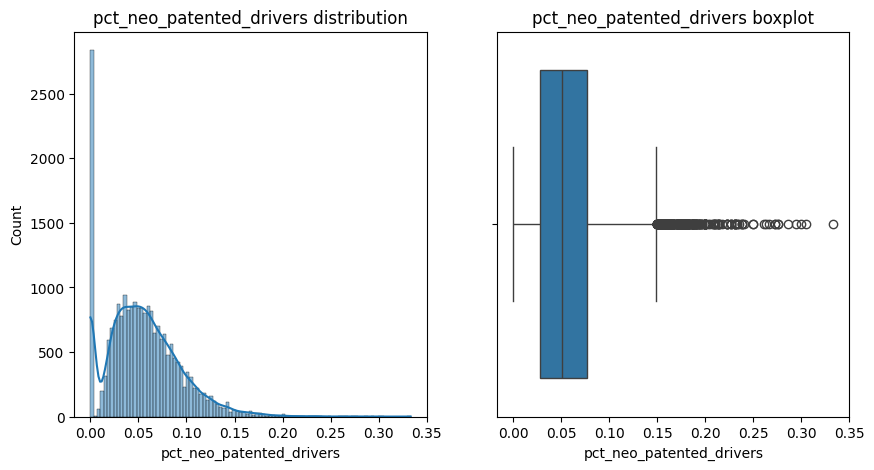

In [3]:
#for each features plot the distribution and a boxplot for each feature
for feature in selected_features:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'{feature} distribution')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[feature])
    plt.title(f'{feature} boxplot')
    plt.show()

## Fatality rate

We use the 0.995 quantile to remove some outliers of the fatality rate.

In [4]:
percentile_99 = df['fatality_rate'].quantile(0.995)
outliers = df[df['fatality_rate'] > percentile_99]
outliers_count = outliers.copy()
outliers

,CRASH_YEAR,CRASH_MONTH,BEAT_OF_OCCURRENCE,avg_responsibility_score,avg_weather_severity,avg_roadway_severity,avg_lighting_severity,total_crashes,fatality_rate,severe_injury_rate,avg_crash_severity_score,injury_severity_score,total_units_department,night_crash_rate,adverse_weather_crash_rate,road_defect_crash_rate,speeding_influence,weekend_crash_rate,neo_patented_drivers,senior_drivers,total_drivers,num_towed_units_LB,damage_low,damage_medium,damage_high,damage_cost_LB,sum_lighting_category_daylight,sum_lighting_category_night,sum_lighting_category_unknown,sum_roadway_surface_category_dry,sum_roadway_surface_category_wet,sum_roadway_surface_category_snow,sum_roadway_surface_category_ice,sum_roadway_surface_category_unknown,sum_road_defect_category_no_defects,sum_road_defect_category_bad,sum_road_defect_category_defect,sum_road_defect_category_debris,sum_road_defect_category_unknown,sum_damage_category_high,sum_damage_category_low,sum_damage_category_medium,sum_category_motorcycle,sum_category_off-road/specialized,sum_category_passenger vehicle,sum_category_public transport,sum_category_truck/commercial,avg_age,pct_neo_patented_drivers,pct_senior_drivers,monthly_total_units,vehicle_involvement_rate,combined_weather_road_severity
46,2018,1,432.0,0.715385,1.076923,1.000000,0.600000,27,0.027778,0.000000,0.057619,35.0,51,0.444444,0.370370,0.000000,0.111111,0.037037,2.0,3.0,40.0,3,6,5,16,32000,13,12,2,11,6,8,1,1,25,0,0,0,2,16,6,5,0.0,0.0,31.0,1.0,0.0,45.125000,0.050000,0.075000,18895,0.002699,1.030769
583,2018,3,433.0,0.776923,0.210526,0.187500,0.578947,19,0.026316,0.035088,0.072020,21.0,37,0.368421,0.105263,0.000000,0.105263,0.263158,7.0,2.0,30.0,4,1,3,15,26000,12,7,0,15,4,0,0,0,16,0,0,0,3,15,1,3,0.0,0.0,24.0,0.0,3.0,36.040000,0.233333,0.066667,18450,0.002005,0.196711
1399,2018,6,533.0,0.600000,0.000000,0.444444,0.400000,10,0.050000,0.000000,0.079206,15.0,18,0.200000,0.000000,0.200000,0.200000,0.100000,2.0,0.0,16.0,1,1,3,6,12500,8,2,0,9,0,0,0,1,7,1,1,0,1,6,1,3,0.0,1.0,11.0,0.0,1.0,35.181818,0.125000,0.000000,21122,0.000852,0.266667
1415,2018,6,714.0,0.590909,0.333333,0.684211,0.190476,21,0.031746,0.000000,0.077220,21.0,40,0.142857,0.142857,0.142857,0.000000,0.000000,4.0,0.0,37.0,6,2,3,16,28000,18,3,0,16,5,0,0,0,16,3,0,0,2,16,2,3,0.0,0.0,32.0,0.0,2.0,35.935484,0.108108,0.000000,21122,0.001894,0.543860
1681,2018,7,711.0,0.857143,0.125000,0.133333,0.500000,16,0.031250,0.000000,0.054630,11.0,31,0.375000,0.062500,0.062500,0.187500,0.312500,0.0,1.0,26.0,3,3,1,12,20500,10,6,0,15,1,0,0,0,14,0,1,0,1,12,3,1,1.0,0.0,17.0,0.0,0.0,41.166667,0.000000,0.038462,20554,0.001508,0.130000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21143,2024,7,2222.0,0.660000,0.000000,0.133333,0.421053,19,0.026316,0.000000,0.138415,12.0,37,0.263158,0.000000,0.052632,0.105263,0.052632,3.0,3.0,29.0,2,3,3,13,24000,14,5,0,19,0,0,0,0,14,0,0,1,4,13,3,3,0.0,0.0,27.0,0.0,0.0,38.263158,0.103448,0.103448,19250,0.001922,0.080000
21146,2024,7,2233.0,0.475000,0.000000,0.000000,0.315789,19,0.026316,0.026316,0.093772,18.0,37,0.263158,0.000000,0.000000,0.105263,0.000000,0.0,2.0,29.0,1,1,3,15,26000,14,5,0,18,0,0,0,1,15,0,0,0,4,15,1,3,0.0,0.0,24.0,1.0,2.0,40.550000,0.000000,0.068966,19250,0.001922,0.000000
21419,2024,8,2422.0,0.680000,0.062500,0.000000,0.277778,20,0.025000,0.050000,0.064817,20.0,40,0.250000,0.000000,0.000000,0.050000,0.150000,0.0,1.0,27.0,0,4,5,11,23500,13,5,2,14,0,0,0,6,13,0,0,0,7,11,4,5,0.0,0.0,19.0,0.0,1.0,45.277778,0.000000,0.037037,19949,0.002005,0.025000
22032,2024,11,522.0,0.300000,0.428571,0.166667,1.000000,7,0.071429,0.000000,0.118677,11.0,15,0.571429,0.142857,0.000000,0.142857,0.285714,2.0,1.0,12.0,0,1,1,5,9000,3,4,0,6,1,0,0,0,6,0,0,0,1,5,1,1,0.0,0.0,10.0,0.0,0.0,37.571429,0.166667,0.083333,17896,0.000838,0.271429


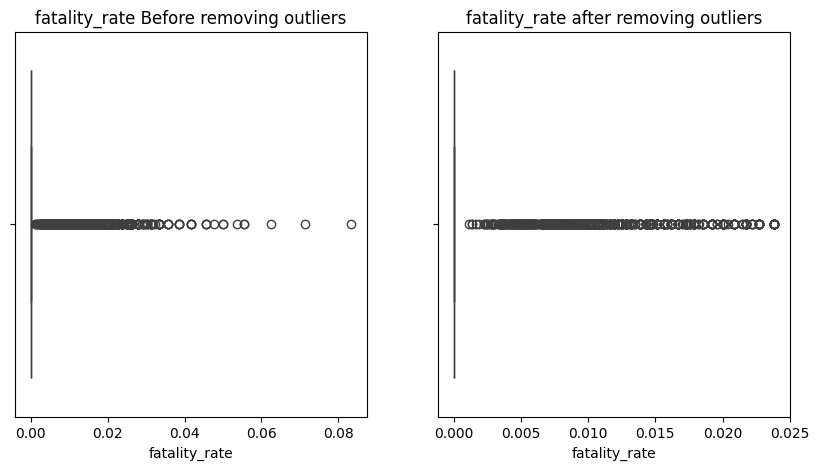

In [5]:
df_cleaned = df.drop(outliers.index)
feature = 'fatality_rate'
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df[feature])
plt.title(f'{feature} Before removing outliers')
plt.subplot(1, 2, 2)
sns.boxplot(x=df_cleaned[feature])
plt.title(f'{feature} after removing outliers')
plt.show()

## AVERAGE CRASH SEVERITY

We use the IQR Method, since the data is right-skewed we use the upperbound and we use 2.5 instead of 1.5 to remove higher outliers.

In [6]:
Q1 = df['avg_crash_severity_score'].quantile(0.25)
Q3 = df['avg_crash_severity_score'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 +  2.5 * IQR
outliers = df[(df['avg_crash_severity_score'] > upper_bound)]
outliers_count = pd.concat([outliers_count, outliers])
outliers

,CRASH_YEAR,CRASH_MONTH,BEAT_OF_OCCURRENCE,avg_responsibility_score,avg_weather_severity,avg_roadway_severity,avg_lighting_severity,total_crashes,fatality_rate,severe_injury_rate,avg_crash_severity_score,injury_severity_score,total_units_department,night_crash_rate,adverse_weather_crash_rate,road_defect_crash_rate,speeding_influence,weekend_crash_rate,neo_patented_drivers,senior_drivers,total_drivers,num_towed_units_LB,damage_low,damage_medium,damage_high,damage_cost_LB,sum_lighting_category_daylight,sum_lighting_category_night,sum_lighting_category_unknown,sum_roadway_surface_category_dry,sum_roadway_surface_category_wet,sum_roadway_surface_category_snow,sum_roadway_surface_category_ice,sum_roadway_surface_category_unknown,sum_road_defect_category_no_defects,sum_road_defect_category_bad,sum_road_defect_category_defect,sum_road_defect_category_debris,sum_road_defect_category_unknown,sum_damage_category_high,sum_damage_category_low,sum_damage_category_medium,sum_category_motorcycle,sum_category_off-road/specialized,sum_category_passenger vehicle,sum_category_public transport,sum_category_truck/commercial,avg_age,pct_neo_patented_drivers,pct_senior_drivers,monthly_total_units,vehicle_involvement_rate,combined_weather_road_severity
131,2018,1,1115.0,0.730769,0.666667,0.857143,0.523810,23,0.000000,0.021739,0.126427,10.0,44,0.347826,0.217391,0.130435,0.043478,0.086957,3.0,2.0,36.0,4,7,5,11,25000,13,8,2,12,6,4,0,1,19,0,0,3,1,11,7,5,0.0,0.0,27.0,0.0,1.0,39.095238,0.083333,0.055556,18895,0.002329,0.780952
250,2018,1,2431.0,0.600000,0.000000,0.125000,0.125000,8,0.000000,0.000000,0.148189,2.0,15,0.125000,0.000000,0.000000,0.125000,0.000000,1.0,0.0,9.0,2,1,3,4,9500,7,1,0,7,1,0,0,0,8,0,0,0,0,4,1,3,0.0,0.0,8.0,0.0,0.0,28.000000,0.111111,0.000000,18895,0.000794,0.075000
286,2018,2,223.0,0.612500,1.176471,0.933333,0.470588,17,0.000000,0.029412,0.140197,7.0,34,0.352941,0.411765,0.000000,0.058824,0.058824,0.0,4.0,25.0,2,3,8,6,18500,11,6,0,6,6,5,0,0,15,0,0,0,2,6,3,8,0.0,0.0,19.0,3.0,1.0,49.705882,0.000000,0.160000,17104,0.001988,1.030588
392,2018,2,1032.0,0.622222,1.315789,1.222222,0.315789,19,0.000000,0.052632,0.117495,12.0,39,0.210526,0.421053,0.052632,0.052632,0.052632,0.0,1.0,32.0,2,4,2,13,23500,15,4,0,6,3,9,0,1,17,0,1,0,1,13,4,2,0.0,0.0,26.0,0.0,2.0,36.400000,0.000000,0.031250,17104,0.002280,1.259649
500,2018,2,2032.0,0.560000,1.066667,0.615385,0.400000,15,0.000000,0.000000,0.115827,3.0,31,0.400000,0.333333,0.000000,0.066667,0.000000,1.0,1.0,24.0,3,5,2,8,16500,9,6,0,9,0,6,0,0,13,0,0,0,2,8,5,2,0.0,0.0,22.0,0.0,0.0,42.166667,0.041667,0.041667,17104,0.001812,0.795897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21521,2024,9,731.0,0.662500,0.125000,0.357143,0.750000,17,0.000000,0.000000,0.128444,5.0,33,0.588235,0.058824,0.117647,0.117647,0.058824,4.0,1.0,27.0,1,3,2,12,21500,6,10,1,15,1,0,0,1,12,1,1,0,3,12,3,2,0.0,0.0,23.0,1.0,0.0,36.466667,0.148148,0.037037,19661,0.001678,0.264286
21577,2024,9,1125.0,0.657143,0.200000,0.125000,0.700000,10,0.000000,0.050000,0.125430,8.0,18,0.600000,0.100000,0.000000,0.300000,0.200000,0.0,0.0,17.0,1,1,3,6,12500,4,6,0,9,1,0,0,0,8,0,0,0,2,6,1,3,0.0,0.0,15.0,0.0,1.0,36.571429,0.000000,0.000000,19661,0.000916,0.155000
22032,2024,11,522.0,0.300000,0.428571,0.166667,1.000000,7,0.071429,0.000000,0.118677,11.0,15,0.571429,0.142857,0.000000,0.142857,0.285714,2.0,1.0,12.0,0,1,1,5,9000,3,4,0,6,1,0,0,0,6,0,0,0,1,5,1,1,0.0,0.0,10.0,0.0,0.0,37.571429,0.166667,0.083333,17896,0.000838,0.271429
22204,2024,11,1933.0,0.580000,0.846154,0.600000,0.571429,16,0.000000,0.000000,0.126675,1.0,30,0.375000,0.187500,0.125000,0.000000,0.000000,0.0,3.0,25.0,2,3,3,10,19500,8,6,2,9,3,1,0,3,8,0,1,1,6,10,3,3,0.0,0.0,22.0,0.0,0.0,43.235294,0.000000,0.120000,17896,0.001676,0.698462


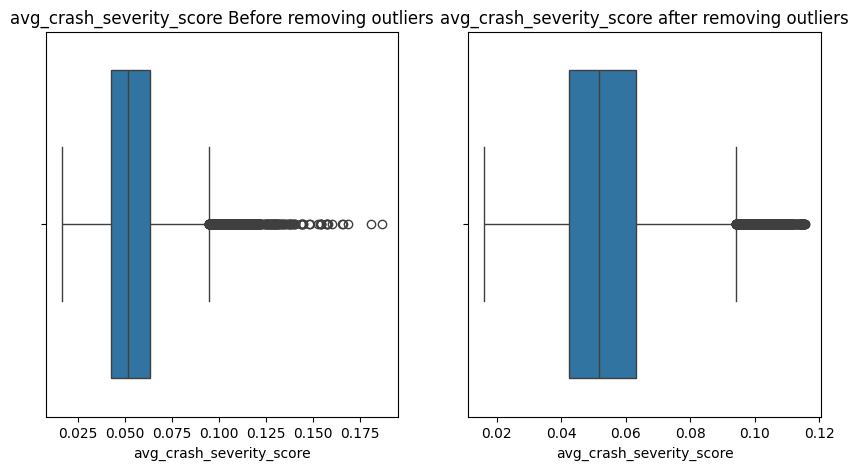

In [7]:
df_cleaned = df.drop(outliers.index)
feature = 'avg_crash_severity_score'
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df[feature])
plt.title(f'{feature} Before removing outliers')
plt.subplot(1, 2, 2)
sns.boxplot(x=df_cleaned[feature])
plt.title(f'{feature} after removing outliers')
plt.show()

## WEEKEND_CRASH_RATE

In [8]:
from sklearn.ensemble import IsolationForest
# The contamiantion is used to set the percentage of outliers in the dataset
clf = IsolationForest(contamination=0.005)
clf.fit(df['weekend_crash_rate'].values.reshape(-1, 1))
outliers = df[clf.predict(df['weekend_crash_rate'].values.reshape(-1, 1)) == -1]
outliers_count = pd.concat([outliers_count, outliers])
outliers

,CRASH_YEAR,CRASH_MONTH,BEAT_OF_OCCURRENCE,avg_responsibility_score,avg_weather_severity,avg_roadway_severity,avg_lighting_severity,total_crashes,fatality_rate,severe_injury_rate,avg_crash_severity_score,injury_severity_score,total_units_department,night_crash_rate,adverse_weather_crash_rate,road_defect_crash_rate,speeding_influence,weekend_crash_rate,neo_patented_drivers,senior_drivers,total_drivers,num_towed_units_LB,damage_low,damage_medium,damage_high,damage_cost_LB,sum_lighting_category_daylight,sum_lighting_category_night,sum_lighting_category_unknown,sum_roadway_surface_category_dry,sum_roadway_surface_category_wet,sum_roadway_surface_category_snow,sum_roadway_surface_category_ice,sum_roadway_surface_category_unknown,sum_road_defect_category_no_defects,sum_road_defect_category_bad,sum_road_defect_category_defect,sum_road_defect_category_debris,sum_road_defect_category_unknown,sum_damage_category_high,sum_damage_category_low,sum_damage_category_medium,sum_category_motorcycle,sum_category_off-road/specialized,sum_category_passenger vehicle,sum_category_public transport,sum_category_truck/commercial,avg_age,pct_neo_patented_drivers,pct_senior_drivers,monthly_total_units,vehicle_involvement_rate,combined_weather_road_severity
290,2018,2,232.0,0.466667,0.857143,1.666667,0.833333,7,0.0,0.000000,0.024332,1.0,15,0.571429,0.285714,0.142857,0.000000,0.428571,1.0,0.0,11.0,2,1,2,4,8500,2,4,1,2,2,1,1,1,5,1,0,0,1,4,1,2,0.0,0.0,9.0,0.0,0.0,32.714286,0.090909,0.000000,17104,0.000877,1.342857
311,2018,2,422.0,0.366667,0.142857,1.000000,0.000000,8,0.0,0.000000,0.045136,3.0,15,0.000000,0.000000,0.000000,0.000000,0.375000,0.0,0.0,11.0,2,1,1,6,10500,7,0,1,4,1,2,0,1,5,0,0,0,3,6,1,1,0.0,0.0,6.0,0.0,2.0,41.500000,0.000000,0.000000,17104,0.000877,0.657143
857,2018,4,522.0,0.650000,0.200000,0.222222,0.500000,10,0.0,0.000000,0.050329,0.0,19,0.400000,0.100000,0.100000,0.000000,0.400000,0.0,2.0,13.0,4,2,0,8,13000,6,4,0,9,1,0,0,0,8,0,1,0,1,8,2,0,0.0,0.0,10.0,0.0,0.0,55.000000,0.000000,0.153846,19252,0.000987,0.213333
1627,2018,7,222.0,0.650000,0.133333,0.000000,0.400000,16,0.0,0.000000,0.055282,0.0,30,0.187500,0.062500,0.000000,0.250000,0.375000,0.0,2.0,24.0,2,0,8,8,20000,12,3,1,14,1,0,0,1,14,0,0,0,2,8,0,8,0.0,0.0,22.0,0.0,0.0,43.642857,0.000000,0.083333,20554,0.001460,0.053333
1986,2018,8,932.0,0.550000,0.181818,0.100000,0.181818,12,0.0,0.041667,0.107686,7.0,26,0.166667,0.083333,0.000000,0.000000,0.416667,0.0,2.0,17.0,2,2,2,8,15000,9,2,1,10,1,0,0,1,10,0,0,0,2,8,2,2,0.0,0.0,13.0,0.0,1.0,48.375000,0.000000,0.117647,20384,0.001276,0.132727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21473,2024,9,324.0,0.745455,0.214286,0.100000,0.464286,32,0.0,0.000000,0.080680,8.0,64,0.250000,0.093750,0.000000,0.156250,0.406250,2.0,4.0,55.0,3,1,8,23,43000,20,8,4,24,3,0,0,5,21,0,0,0,11,23,1,8,1.0,0.0,45.0,0.0,1.0,43.450000,0.036364,0.072727,19661,0.003255,0.145714
21485,2024,9,424.0,0.628571,0.307692,0.272727,0.538462,13,0.0,0.000000,0.046879,3.0,29,0.384615,0.153846,0.000000,0.076923,0.384615,3.0,0.0,21.0,5,0,2,11,18500,8,5,0,10,3,0,0,0,11,0,0,0,2,11,0,2,0.0,0.0,19.0,0.0,0.0,32.000000,0.142857,0.000000,19661,0.001475,0.286713
22330,2024,12,732.0,0.633333,0.500000,0.285714,0.875000,8,0.0,0.000000,0.045568,0.0,16,0.750000,0.125000,0.000000,0.000000,0.375000,0.0,0.0,12.0,2,1,1,6,10500,2,6,0,5,2,0,0,1,8,0,0,0,0,6,1,1,0.0,0.0,11.0,0.0,0.0,41.777778,0.000000,0.000000,17543,0.000912,0.371429
22403,2024,12,1234.0,0.672727,0.304348,0.210526,0.666667,24,0.0,0.000000,0.037980,1.0,53,0.500000,0.125000,0.041667,0.000000,0.375000,3.0,1.0,41.0,4,3,2,19,32000,12,12,0,19,3,0,0,2,18,0,0,1,5,19,3,2,0.0,0.0,37.0,1.0,0.0,41.370370,0.073171,0.024390,17543,0.003021,0.248055


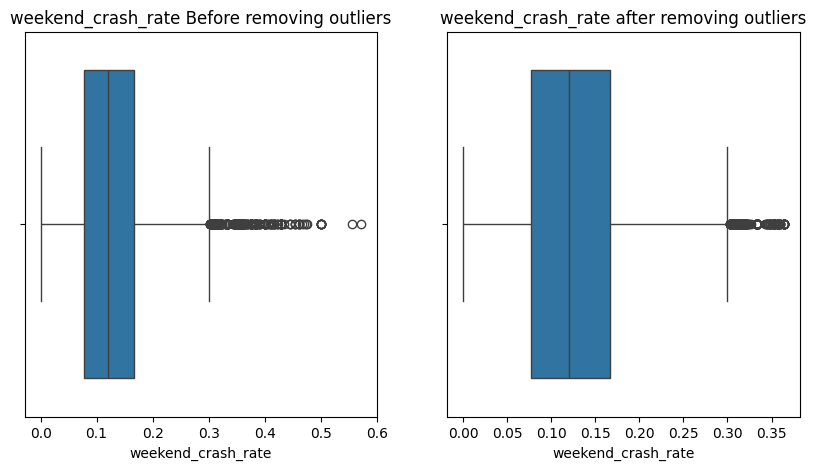

In [9]:
df_cleaned = df.drop(outliers.index)
feature = 'weekend_crash_rate'
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df[feature])
plt.title(f'{feature} Before removing outliers')
plt.subplot(1, 2, 2)
sns.boxplot(x=df_cleaned[feature])
plt.title(f'{feature} after removing outliers')
plt.show()

## pct_neo_patented_drivers

In [10]:
#isolation forest in the feature "weekend_crash_rate"
from sklearn.ensemble import IsolationForest
# The contamiantion is used to set the percentage of outliers in the dataset
clf = IsolationForest(contamination=0.005)
clf.fit(df['pct_neo_patented_drivers'].values.reshape(-1, 1))
outliers = df[clf.predict(df['pct_neo_patented_drivers'].values.reshape(-1, 1)) == -1]
outliers_count = pd.concat([outliers_count, outliers])
outliers

,CRASH_YEAR,CRASH_MONTH,BEAT_OF_OCCURRENCE,avg_responsibility_score,avg_weather_severity,avg_roadway_severity,avg_lighting_severity,total_crashes,fatality_rate,severe_injury_rate,avg_crash_severity_score,injury_severity_score,total_units_department,night_crash_rate,adverse_weather_crash_rate,road_defect_crash_rate,speeding_influence,weekend_crash_rate,neo_patented_drivers,senior_drivers,total_drivers,num_towed_units_LB,damage_low,damage_medium,damage_high,damage_cost_LB,sum_lighting_category_daylight,sum_lighting_category_night,sum_lighting_category_unknown,sum_roadway_surface_category_dry,sum_roadway_surface_category_wet,sum_roadway_surface_category_snow,sum_roadway_surface_category_ice,sum_roadway_surface_category_unknown,sum_road_defect_category_no_defects,sum_road_defect_category_bad,sum_road_defect_category_defect,sum_road_defect_category_debris,sum_road_defect_category_unknown,sum_damage_category_high,sum_damage_category_low,sum_damage_category_medium,sum_category_motorcycle,sum_category_off-road/specialized,sum_category_passenger vehicle,sum_category_public transport,sum_category_truck/commercial,avg_age,pct_neo_patented_drivers,pct_senior_drivers,monthly_total_units,vehicle_involvement_rate,combined_weather_road_severity
583,2018,3,433.0,0.776923,0.210526,0.187500,0.578947,19,0.026316,0.035088,0.072020,21.0,37,0.368421,0.105263,0.000000,0.105263,0.263158,7.0,2.0,30.0,4,1,3,15,26000,12,7,0,15,4,0,0,0,16,0,0,0,3,15,1,3,0.0,0.0,24.0,0.0,3.0,36.040000,0.233333,0.066667,18450,0.002005,0.196711
588,2018,3,522.0,0.725000,0.000000,0.000000,1.166667,7,0.000000,0.000000,0.048743,1.0,16,0.714286,0.000000,0.000000,0.142857,0.142857,3.0,0.0,10.0,1,0,2,5,9500,1,5,1,7,0,0,0,0,6,0,0,0,1,5,0,2,0.0,0.0,9.0,0.0,0.0,27.888889,0.300000,0.000000,18450,0.000867,0.000000
853,2018,4,434.0,0.655556,0.666667,0.352941,0.611111,20,0.000000,0.000000,0.077789,4.0,34,0.400000,0.250000,0.000000,0.150000,0.100000,6.0,0.0,30.0,4,3,5,12,24500,10,8,2,11,6,0,0,3,17,0,0,0,3,12,3,5,1.0,0.0,22.0,0.0,2.0,35.375000,0.200000,0.000000,19252,0.001766,0.478431
855,2018,4,512.0,0.628571,0.333333,0.222222,0.222222,9,0.000000,0.055556,0.098420,7.0,19,0.222222,0.111111,0.000000,0.111111,0.222222,3.0,1.0,16.0,2,3,1,5,10000,7,2,0,7,2,0,0,0,9,0,0,0,0,5,3,1,0.0,0.0,16.0,0.0,0.0,34.000000,0.187500,0.062500,19252,0.000987,0.266667
1088,2018,5,221.0,0.616667,0.000000,0.000000,0.357143,14,0.000000,0.000000,0.034326,2.0,27,0.285714,0.000000,0.071429,0.071429,0.000000,5.0,0.0,24.0,2,2,4,8,17000,10,4,0,12,0,0,0,2,12,0,0,1,1,8,2,4,0.0,0.0,21.0,0.0,1.0,33.647059,0.208333,0.000000,21333,0.001266,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20889,2024,6,2513.0,0.635714,0.000000,0.000000,0.217391,24,0.000000,0.020833,0.055010,10.0,53,0.166667,0.000000,0.000000,0.041667,0.291667,9.0,3.0,43.0,3,0,3,21,34500,19,4,1,18,1,0,0,5,13,0,0,0,11,21,0,3,0.0,0.0,41.0,0.0,1.0,35.600000,0.209302,0.069767,20332,0.002607,0.000000
21692,2024,9,2431.0,0.640000,0.111111,0.000000,0.666667,11,0.000000,0.000000,0.106309,3.0,22,0.363636,0.000000,0.000000,0.000000,0.181818,3.0,0.0,16.0,1,2,2,7,13500,5,4,2,9,0,0,0,2,6,0,0,0,5,7,2,2,0.0,0.0,16.0,0.0,0.0,34.000000,0.187500,0.000000,19661,0.001119,0.044444
22022,2024,11,422.0,0.766667,0.285714,0.200000,0.375000,8,0.000000,0.000000,0.051219,0.0,17,0.250000,0.125000,0.000000,0.000000,0.000000,2.0,0.0,9.0,3,0,3,5,10500,6,2,0,5,1,0,0,2,7,0,0,0,1,5,0,3,0.0,0.0,7.0,0.0,1.0,36.800000,0.222222,0.000000,17896,0.000950,0.234286
22268,2024,12,224.0,0.750000,1.111111,0.500000,0.636364,11,0.000000,0.000000,0.064877,0.0,22,0.545455,0.454545,0.000000,0.090909,0.181818,5.0,2.0,22.0,3,0,1,10,16000,5,6,0,4,5,0,0,2,6,0,0,0,5,10,0,1,0.0,0.0,18.0,0.0,1.0,36.684211,0.227273,0.090909,17543,0.001254,0.744444


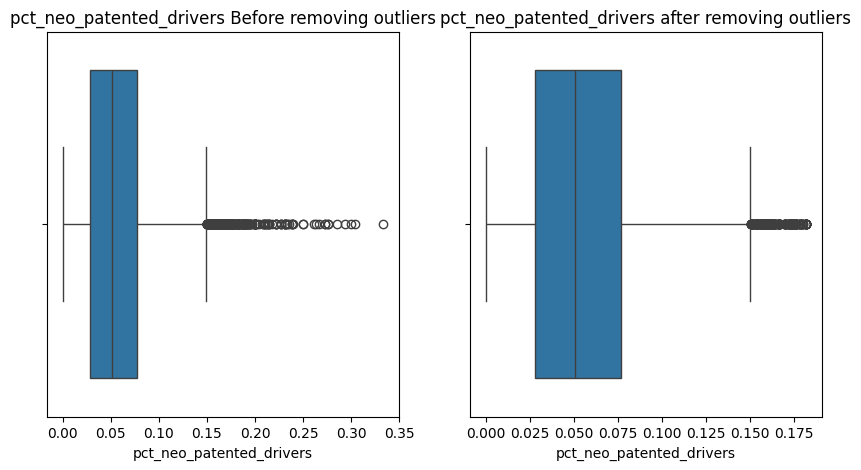

In [11]:
df_cleaned = df.drop(outliers.index)
feature = 'pct_neo_patented_drivers'
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df[feature])
plt.title(f'{feature} Before removing outliers')
plt.subplot(1, 2, 2)
sns.boxplot(x=df_cleaned[feature])
plt.title(f'{feature} after removing outliers')
plt.show()

## Damage_cost_LB

In [12]:
Q1 = df['damage_cost_LB'].quantile(0.25)
Q3 = df['damage_cost_LB'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 +  2.5 * IQR
outliers = df[(df['damage_cost_LB'] > upper_bound)]
outliers_count = pd.concat([outliers_count, outliers])
outliers

,CRASH_YEAR,CRASH_MONTH,BEAT_OF_OCCURRENCE,avg_responsibility_score,avg_weather_severity,avg_roadway_severity,avg_lighting_severity,total_crashes,fatality_rate,severe_injury_rate,avg_crash_severity_score,injury_severity_score,total_units_department,night_crash_rate,adverse_weather_crash_rate,road_defect_crash_rate,speeding_influence,weekend_crash_rate,neo_patented_drivers,senior_drivers,total_drivers,num_towed_units_LB,damage_low,damage_medium,damage_high,damage_cost_LB,sum_lighting_category_daylight,sum_lighting_category_night,sum_lighting_category_unknown,sum_roadway_surface_category_dry,sum_roadway_surface_category_wet,sum_roadway_surface_category_snow,sum_roadway_surface_category_ice,sum_roadway_surface_category_unknown,sum_road_defect_category_no_defects,sum_road_defect_category_bad,sum_road_defect_category_defect,sum_road_defect_category_debris,sum_road_defect_category_unknown,sum_damage_category_high,sum_damage_category_low,sum_damage_category_medium,sum_category_motorcycle,sum_category_off-road/specialized,sum_category_passenger vehicle,sum_category_public transport,sum_category_truck/commercial,avg_age,pct_neo_patented_drivers,pct_senior_drivers,monthly_total_units,vehicle_involvement_rate,combined_weather_road_severity
210,2018,1,1834.0,0.689706,0.473214,0.490741,0.594828,118,0.0,0.009887,0.058335,29.0,240,0.449153,0.161017,0.025424,0.110169,0.050847,2.0,13.0,219.0,15,19,36,63,140000,63,53,2,79,24,5,5,5,106,3,0,0,9,63,19,36,0.0,0.0,194.0,7.0,8.0,41.989189,0.009132,0.059361,18895,0.012702,0.483730
477,2018,2,1834.0,0.672857,0.557522,0.737864,0.529412,120,0.0,0.004167,0.059679,13.0,238,0.425000,0.183333,0.058333,0.100000,0.100000,7.0,14.0,220.0,10,16,50,54,139000,68,51,1,65,30,14,1,10,98,5,0,2,15,54,16,50,1.0,0.0,189.0,7.0,4.0,41.464286,0.031818,0.063636,17104,0.013915,0.665727
689,2018,3,1232.0,0.678333,0.216981,0.110000,0.528302,107,0.0,0.014019,0.051507,21.0,209,0.392523,0.084112,0.009346,0.037383,0.149533,10.0,8.0,192.0,10,15,30,62,130500,64,42,1,94,10,0,0,3,99,0,0,1,7,62,15,30,0.0,1.0,162.0,3.0,10.0,39.706294,0.052083,0.041667,18450,0.011328,0.152792
743,2018,3,1831.0,0.646269,0.043860,0.080808,0.535088,118,0.0,0.008475,0.042993,13.0,240,0.449153,0.016949,0.025424,0.067797,0.144068,1.0,14.0,221.0,13,23,39,56,134500,61,53,4,105,4,0,0,9,96,1,2,0,19,56,23,39,1.0,0.0,195.0,4.0,7.0,41.189189,0.004525,0.063348,18450,0.013008,0.066029
746,2018,3,1834.0,0.651316,0.139344,0.127273,0.300813,126,0.0,0.000000,0.040205,3.0,249,0.246032,0.055556,0.015873,0.087302,0.126984,15.0,6.0,229.0,13,22,48,56,143000,92,31,3,107,8,1,0,10,109,1,0,1,15,56,22,48,0.0,0.0,186.0,9.0,11.0,40.398876,0.065502,0.026201,18450,0.013496,0.132101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21528,2024,9,813.0,0.634426,0.287037,0.114943,0.247706,119,0.0,0.000000,0.047686,13.0,248,0.176471,0.117647,0.008403,0.067227,0.201681,7.0,13.0,215.0,8,7,37,75,153000,88,21,10,92,14,0,0,13,86,1,0,0,32,75,7,37,2.0,0.0,176.0,5.0,6.0,42.360248,0.032558,0.060465,19661,0.012614,0.183780
21530,2024,9,815.0,0.635185,0.160000,0.112500,0.465347,107,0.0,0.004206,0.045281,30.0,222,0.317757,0.074766,0.000000,0.084112,0.102804,10.0,12.0,193.0,10,7,23,77,142000,67,34,6,86,10,0,0,11,80,0,0,0,27,77,7,23,3.0,0.0,164.0,3.0,8.0,40.039216,0.051813,0.062176,19661,0.011291,0.131500
22191,2024,11,1834.0,0.664444,0.537634,0.275362,0.677083,103,0.0,0.000000,0.057883,4.0,201,0.504854,0.184466,0.000000,0.203883,0.135922,2.0,10.0,184.0,10,7,24,72,135500,44,52,7,62,21,3,0,17,70,0,0,0,33,72,7,24,1.0,0.0,151.0,12.0,5.0,41.870229,0.010870,0.054348,17896,0.011232,0.380271
22336,2024,12,813.0,0.643396,0.400000,0.289855,0.637363,99,0.0,0.000000,0.046384,8.0,203,0.494949,0.141414,0.020202,0.070707,0.212121,9.0,16.0,180.0,17,3,21,75,135000,42,49,8,67,12,2,2,16,70,0,1,1,27,75,3,21,0.0,0.0,160.0,4.0,3.0,42.375887,0.050000,0.088889,17543,

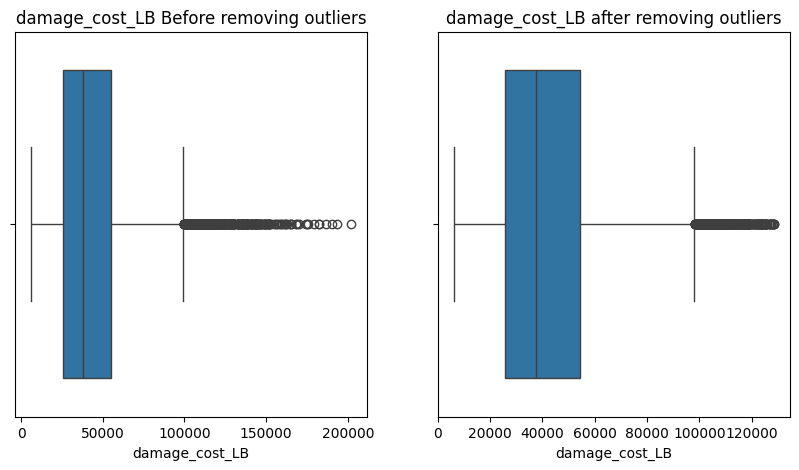

In [13]:
df_cleaned = df.drop(outliers.index)
feature = 'damage_cost_LB'
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df[feature])
plt.title(f'{feature} Before removing outliers')
plt.subplot(1, 2, 2)
sns.boxplot(x=df_cleaned[feature])
plt.title(f'{feature} after removing outliers')
plt.show()

## avg_lighting_severity

In [14]:
Q1 = df['avg_lighting_severity'].quantile(0.25)
Q3 = df['avg_lighting_severity'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 +  2 * IQR
outliers = df[(df['avg_lighting_severity'] > upper_bound)]
outliers_count = pd.concat([outliers_count, outliers])
outliers

,CRASH_YEAR,CRASH_MONTH,BEAT_OF_OCCURRENCE,avg_responsibility_score,avg_weather_severity,avg_roadway_severity,avg_lighting_severity,total_crashes,fatality_rate,severe_injury_rate,avg_crash_severity_score,injury_severity_score,total_units_department,night_crash_rate,adverse_weather_crash_rate,road_defect_crash_rate,speeding_influence,weekend_crash_rate,neo_patented_drivers,senior_drivers,total_drivers,num_towed_units_LB,damage_low,damage_medium,damage_high,damage_cost_LB,sum_lighting_category_daylight,sum_lighting_category_night,sum_lighting_category_unknown,sum_roadway_surface_category_dry,sum_roadway_surface_category_wet,sum_roadway_surface_category_snow,sum_roadway_surface_category_ice,sum_roadway_surface_category_unknown,sum_road_defect_category_no_defects,sum_road_defect_category_bad,sum_road_defect_category_defect,sum_road_defect_category_debris,sum_road_defect_category_unknown,sum_damage_category_high,sum_damage_category_low,sum_damage_category_medium,sum_category_motorcycle,sum_category_off-road/specialized,sum_category_passenger vehicle,sum_category_public transport,sum_category_truck/commercial,avg_age,pct_neo_patented_drivers,pct_senior_drivers,monthly_total_units,vehicle_involvement_rate,combined_weather_road_severity
113,2018,1,934.0,0.557143,0.500000,0.444444,1.100000,10,0.000000,0.000000,0.053086,2.0,18,0.600000,0.200000,0.000000,0.200000,0.200000,0.0,0.0,17.0,1,2,4,4,11000,4,6,0,7,1,0,1,1,9,0,0,0,1,4,2,4,0.0,0.0,14.0,0.0,1.0,45.909091,0.000000,0.000000,18895,0.000953,0.466667
135,2018,1,1124.0,0.925000,1.000000,0.875000,1.111111,10,0.000000,0.000000,0.043474,0.0,20,0.600000,0.400000,0.000000,0.000000,0.100000,0.0,1.0,18.0,1,2,3,5,11500,3,6,1,4,3,1,1,1,9,0,0,0,1,5,2,3,0.0,0.0,13.0,0.0,0.0,39.111111,0.000000,0.055556,18895,0.001058,0.925000
588,2018,3,522.0,0.725000,0.000000,0.000000,1.166667,7,0.000000,0.000000,0.048743,1.0,16,0.714286,0.000000,0.000000,0.142857,0.142857,3.0,0.0,10.0,1,0,2,5,9500,1,5,1,7,0,0,0,0,6,0,0,0,1,5,0,2,0.0,0.0,9.0,0.0,0.0,27.888889,0.300000,0.000000,18450,0.000867,0.000000
615,2018,3,726.0,0.620000,0.500000,0.363636,1.083333,12,0.000000,0.041667,0.078596,5.0,24,0.583333,0.166667,0.000000,0.083333,0.000000,1.0,2.0,20.0,3,1,4,7,15000,5,7,0,9,2,1,0,0,11,0,0,0,1,7,1,4,0.0,0.0,19.0,0.0,0.0,45.714286,0.050000,0.100000,18450,0.001301,0.418182
3014,2018,12,713.0,0.785714,0.230769,0.384615,1.117647,17,0.029412,0.029412,0.063767,19.0,32,0.764706,0.058824,0.058824,0.058824,0.411765,2.0,2.0,26.0,0,5,3,9,19000,4,13,0,10,2,1,0,4,14,0,1,0,2,9,5,3,0.0,0.0,22.0,0.0,1.0,36.833333,0.076923,0.076923,19962,0.001603,0.323077
3054,2018,12,933.0,0.750000,0.200000,0.222222,1.181818,11,0.000000,0.000000,0.086776,2.0,20,0.818182,0.090909,0.000000,0.000000,0.000000,0.0,2.0,17.0,2,0,3,8,15000,2,9,0,8,2,0,0,1,10,0,0,0,1,8,0,3,0.0,0.0,10.0,0.0,4.0,47.000000,0.000000,0.117647,19962,0.001002,0.213333
3064,2018,12,1024.0,0.728571,0.307692,0.454545,1.230769,13,0.000000,0.000000,0.076917,0.0,25,0.846154,0.076923,0.076923,0.000000,0.384615,0.0,0.0,19.0,2,3,4,6,14500,2,11,0,8,3,1,0,1,11,0,1,0,1,6,3,4,0.0,0.0,12.0,1.0,1.0,42.250000,0.000000,0.000000,19962,0.001252,0.395804
3161,2018,12,1924.0,0.587500,0.947368,0.529412,1.150000,24,0.000000,0.000000,0.082928,4.0,48,0.666667,0.291667,0.000000,0.208333,0.166667,2.0,3.0,42.0,1,2,8,14,30000,4,16,4,9,7,1,1,6,18,0,0,0,6,14,2,8,0.0,0.0,39.0,0.0,0.0,38.875000,0.047619,0.071429,19962,0.002405,0.696594
3228,2019,1,223.0,0.528571,1.555556,1.250000,1.111111,10,0.000000,0.000000,0.121988,7.0,22,0.600000,0.500000,0.000000,0.200000,0.100000,0.0,2.0,14.0,2,2,2,6,12000,3,6,1,3,1,4,1,1,8,0,0,0,2,6,2,2,0.0,0.0,12.0,0.0,1.0,41.153846,0.000000,0.142857,18001,0.001222,1.372222
3236,2019,1,311.0,0.712500,1.666667,1.384615,1.066667,15,0.000000,0.000000,0.043332,5.0,30,0.733333,0.533333,0.000000,0.133333,0.133333,2.0,2.0,23.0,3,4,3,8,17000,4,11,0,3,3,9,0,0,13,0,0,0,2,8,4,3,0.0,0.0,17.0,1.0,3.0,42.625000,0.086957,0.086957,18001,0.001667,1.497436


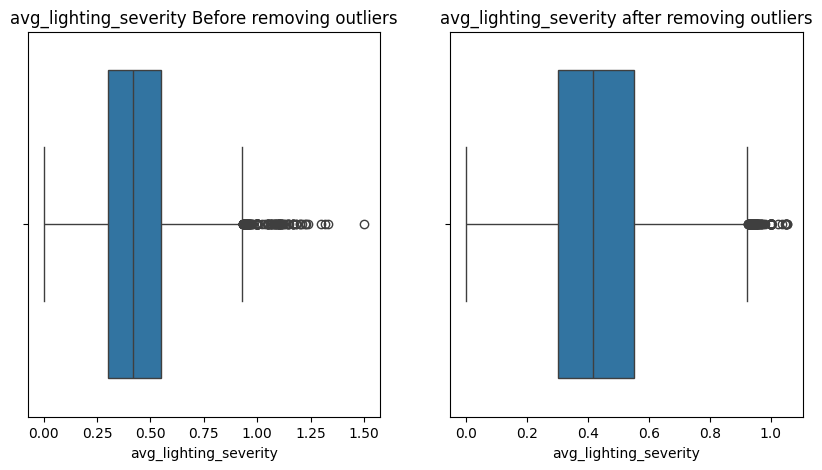

In [15]:
df_cleaned = df.drop(outliers.index)
feature = 'avg_lighting_severity'
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df[feature])
plt.title(f'{feature} Before removing outliers')
plt.subplot(1, 2, 2)
sns.boxplot(x=df_cleaned[feature])
plt.title(f'{feature} after removing outliers')
plt.show()

## combined_weather_road_severity

In [16]:
percentile_99 = df['combined_weather_road_severity'].quantile(0.995)
outliers = df[df['combined_weather_road_severity'] > percentile_99]
outliers_count = pd.concat([outliers_count, outliers])
outliers

,CRASH_YEAR,CRASH_MONTH,BEAT_OF_OCCURRENCE,avg_responsibility_score,avg_weather_severity,avg_roadway_severity,avg_lighting_severity,total_crashes,fatality_rate,severe_injury_rate,avg_crash_severity_score,injury_severity_score,total_units_department,night_crash_rate,adverse_weather_crash_rate,road_defect_crash_rate,speeding_influence,weekend_crash_rate,neo_patented_drivers,senior_drivers,total_drivers,num_towed_units_LB,damage_low,damage_medium,damage_high,damage_cost_LB,sum_lighting_category_daylight,sum_lighting_category_night,sum_lighting_category_unknown,sum_roadway_surface_category_dry,sum_roadway_surface_category_wet,sum_roadway_surface_category_snow,sum_roadway_surface_category_ice,sum_roadway_surface_category_unknown,sum_road_defect_category_no_defects,sum_road_defect_category_bad,sum_road_defect_category_defect,sum_road_defect_category_debris,sum_road_defect_category_unknown,sum_damage_category_high,sum_damage_category_low,sum_damage_category_medium,sum_category_motorcycle,sum_category_off-road/specialized,sum_category_passenger vehicle,sum_category_public transport,sum_category_truck/commercial,avg_age,pct_neo_patented_drivers,pct_senior_drivers,monthly_total_units,vehicle_involvement_rate,combined_weather_road_severity
321,2018,2,522.0,0.466667,1.800000,1.142857,0.666667,10,0.0,0.000000,0.077748,2.0,19,0.600000,0.600000,0.000000,0.100000,0.300000,0.0,0.0,12.0,1,2,1,7,12500,3,6,1,3,1,6,0,0,7,0,0,0,3,7,2,1,0.0,0.0,9.0,0.0,0.0,31.800000,0.000000,0.000000,17104,0.001111,1.405714
325,2018,2,532.0,0.460000,1.428571,2.333333,0.571429,7,0.0,0.000000,0.089457,0.0,12,0.571429,0.571429,0.285714,0.285714,0.000000,0.0,1.0,9.0,2,0,1,6,10000,3,4,0,1,3,3,0,0,4,2,0,0,1,6,0,1,0.0,0.0,8.0,0.0,0.0,48.000000,0.000000,0.111111,17104,0.000702,1.971429
328,2018,2,612.0,0.466667,1.590909,1.235294,0.545455,22,0.0,0.000000,0.028084,0.0,47,0.363636,0.545455,0.000000,0.136364,0.227273,1.0,2.0,34.0,1,5,7,10,24500,14,8,0,8,3,10,0,1,17,0,0,0,5,10,5,7,1.0,0.0,24.0,3.0,3.0,44.727273,0.029412,0.058824,17104,0.002748,1.377540
337,2018,2,633.0,0.677778,1.125000,1.600000,0.352941,17,0.0,0.000000,0.032004,3.0,33,0.294118,0.352941,0.117647,0.176471,0.235294,0.0,4.0,28.0,2,4,8,5,17500,12,5,0,4,4,9,0,0,13,1,1,0,2,5,4,8,0.0,0.0,25.0,0.0,1.0,49.125000,0.000000,0.142857,17104,0.001929,1.410000
379,2018,2,932.0,0.725000,1.909091,1.500000,0.416667,12,0.0,0.041667,0.104851,7.0,26,0.416667,0.583333,0.000000,0.000000,0.083333,0.0,0.0,19.0,3,2,5,5,13500,7,5,0,1,3,6,0,2,11,0,0,0,1,5,2,5,0.0,0.0,16.0,2.0,0.0,36.750000,0.000000,0.000000,17104,0.001520,1.663636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19451,2024,1,1423.0,0.533333,1.545455,1.444444,0.307692,14,0.0,0.000000,0.062941,0.0,30,0.214286,0.500000,0.071429,0.000000,0.142857,1.0,3.0,22.0,2,1,4,9,18000,10,3,1,1,4,5,0,4,8,0,1,0,5,9,1,4,0.0,0.0,20.0,1.0,0.0,38.444444,0.045455,0.136364,16345,0.001835,1.484848
19452,2024,1,1424.0,0.692857,1.615385,1.315789,0.653846,28,0.0,0.000000,0.096875,4.0,56,0.464286,0.500000,0.035714,0.071429,0.035714,2.0,1.0,43.0,2,5,3,20,35500,13,13,2,6,9,9,2,2,18,0,1,0,9,20,5,3,0.0,0.0,34.0,1.0,1.0,38.458333,0.046512,0.023256,16345,0.003426,1.435628
19457,2024,1,1511.0,0.820000,1.600000,1.285714,0.500000,13,0.0,0.000000,0.047771,0.0,29,0.384615,0.384615,0.000000,0.000000,0.153846,0.0,1.0,23.0,4,0,3,10,18000,7,5,1,2,4,3,2,2,7,0,0,0,6,10,0,3,0.0,0.0,19.0,1.0,0.0,34.615385,0.000000,0.043478,16345,0.001774,1.411429
19461,2024,1,1523.0,0.200000,1.777778,1.727273,0.777778,19,0.0,0.000000,0.038251,2.0,42,0.631579,0.578947,0.000000,0.000000,0.157895,1.0,0.0,26.0,3,1,4,14,25500,6,12,1,3,3,8,4,1,11,0,0,0,8,14,1,4,0.0,0.0,20.0,0.0,0.0,36.761905,0.038462,0.000000,16345,0.002570,1.747475


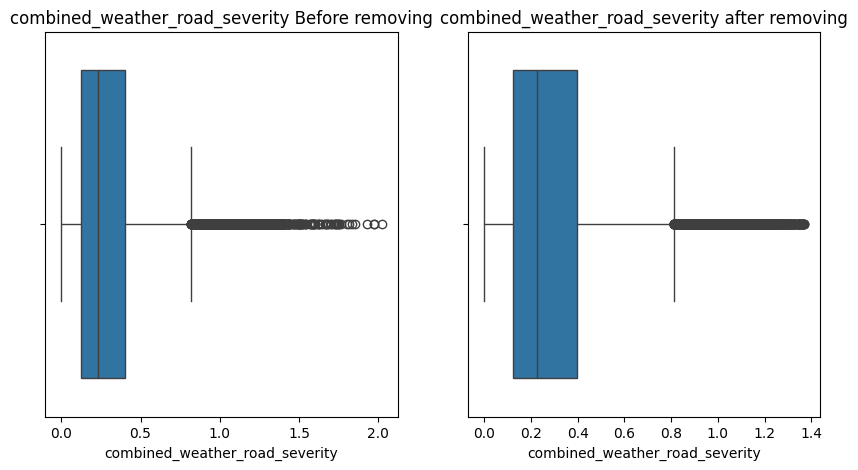

In [17]:
df_cleaned = df.drop(outliers.index)
feature = 'combined_weather_road_severity'
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df[feature])
plt.title(f'{feature} Before removing')
plt.subplot(1, 2, 2)
sns.boxplot(x=df_cleaned[feature])
plt.title(f'{feature} after removing')
plt.show()

# speeding_influence

In [18]:
from sklearn.ensemble import IsolationForest
# The contamiantion is used to set the percentage of outliers in the dataset
clf = IsolationForest(contamination=0.005)
clf.fit(df['speeding_influence'].values.reshape(-1, 1))
outliers = df[clf.predict(df['speeding_influence'].values.reshape(-1, 1)) == -1]
outliers_count = pd.concat([outliers_count, outliers])
outliers

,CRASH_YEAR,CRASH_MONTH,BEAT_OF_OCCURRENCE,avg_responsibility_score,avg_weather_severity,avg_roadway_severity,avg_lighting_severity,total_crashes,fatality_rate,severe_injury_rate,avg_crash_severity_score,injury_severity_score,total_units_department,night_crash_rate,adverse_weather_crash_rate,road_defect_crash_rate,speeding_influence,weekend_crash_rate,neo_patented_drivers,senior_drivers,total_drivers,num_towed_units_LB,damage_low,damage_medium,damage_high,damage_cost_LB,sum_lighting_category_daylight,sum_lighting_category_night,sum_lighting_category_unknown,sum_roadway_surface_category_dry,sum_roadway_surface_category_wet,sum_roadway_surface_category_snow,sum_roadway_surface_category_ice,sum_roadway_surface_category_unknown,sum_road_defect_category_no_defects,sum_road_defect_category_bad,sum_road_defect_category_defect,sum_road_defect_category_debris,sum_road_defect_category_unknown,sum_damage_category_high,sum_damage_category_low,sum_damage_category_medium,sum_category_motorcycle,sum_category_off-road/specialized,sum_category_passenger vehicle,sum_category_public transport,sum_category_truck/commercial,avg_age,pct_neo_patented_drivers,pct_senior_drivers,monthly_total_units,vehicle_involvement_rate,combined_weather_road_severity
2865,2018,11,1654.0,0.600000,1.125000,0.750000,0.888889,9,0.000000,0.000000,0.025904,0.0,18,0.555556,0.444444,0.000000,0.444444,0.111111,0.0,1.0,17.0,1,2,1,6,11000,4,5,0,3,4,1,0,1,9,0,0,0,0,6,2,1,0.0,0.0,14.0,0.0,0.0,38.916667,0.000000,0.058824,18736,0.000961,0.900000
4195,2019,4,1654.0,0.662500,0.750000,0.300000,0.250000,12,0.000000,0.000000,0.054239,5.0,25,0.166667,0.333333,0.000000,0.583333,0.083333,2.0,2.0,25.0,1,0,5,7,15500,10,2,0,7,4,1,0,0,10,0,0,0,2,7,0,5,1.0,0.0,21.0,0.0,2.0,42.666667,0.080000,0.080000,18745,0.001334,0.480000
4463,2019,5,1654.0,0.607692,0.222222,0.588235,0.333333,18,0.027778,0.000000,0.067173,11.0,34,0.222222,0.055556,0.166667,0.555556,0.111111,0.0,3.0,33.0,2,2,5,11,22500,14,4,0,15,3,0,0,0,14,1,0,2,1,11,2,5,0.0,0.0,29.0,1.0,2.0,46.166667,0.000000,0.090909,21297,0.001596,0.441830
4733,2019,6,1654.0,0.650000,0.000000,0.000000,0.000000,9,0.000000,0.000000,0.032702,1.0,19,0.000000,0.000000,0.000000,0.888889,0.000000,0.0,1.0,19.0,1,0,2,7,12500,8,0,1,9,0,0,0,0,9,0,0,0,0,7,0,2,0.0,0.0,17.0,0.0,1.0,45.294118,0.000000,0.052632,21343,0.000890,0.000000
5272,2019,8,1654.0,0.660000,0.266667,0.200000,0.000000,15,0.000000,0.000000,0.027243,1.0,30,0.000000,0.133333,0.000000,0.466667,0.066667,0.0,2.0,27.0,0,1,6,8,18500,15,0,0,12,3,0,0,0,15,0,0,0,0,8,1,6,0.0,0.0,25.0,1.0,0.0,42.428571,0.000000,0.074074,19871,0.001510,0.226667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21361,2024,8,1654.0,0.650000,0.153846,0.076923,0.461538,14,0.000000,0.000000,0.069217,1.0,24,0.285714,0.071429,0.000000,0.500000,0.214286,1.0,0.0,24.0,3,2,1,11,18500,9,4,1,12,1,0,0,1,13,0,0,0,1,11,2,1,0.0,0.0,21.0,0.0,2.0,41.083333,0.041667,0.000000,19949,0.001203,0.107692
21631,2024,9,1654.0,0.637500,0.090909,0.090909,0.454545,11,0.000000,0.000000,0.053740,3.0,22,0.363636,0.000000,0.000000,0.545455,0.181818,1.0,1.0,21.0,2,1,1,9,15000,7,4,0,10,1,0,0,0,11,0,0,0,0,9,1,1,1.0,0.0,17.0,2.0,1.0,38.833333,0.047619,0.047619,19661,0.001119,0.090909
21901,2024,10,1654.0,0.622222,0.058824,0.000000,0.470588,17,0.000000,0.000000,0.035031,1.0,36,0.411765,0.000000,0.000000,0.529412,0.058824,0.0,2.0,35.0,3,3,3,11,21000,10,7,0,16,0,0,0,1,13,0,0,0,4,11,3,3,0.0,0.0,32.0,0.0,2.0,39.560000,0.000000,0.057143,19869,0.001812,0.023529
22170,2024,11,1654.0,0.590000,1.307692,0.727273,0.461538,13,0.000000,0.000000,0.072122,4.0,24,0.384615,0.461538,0.076923,0.538462,0.000000,2.0,2.0,22.0,1,2,1,10,17000,8,5,0,7,3,3,0,0,10,0,1,0,2,10,2,1,0.0,0.0,20.0,1.0,0.0,38.166667,0.090909,0.090909,17896,0.001341,0.959441


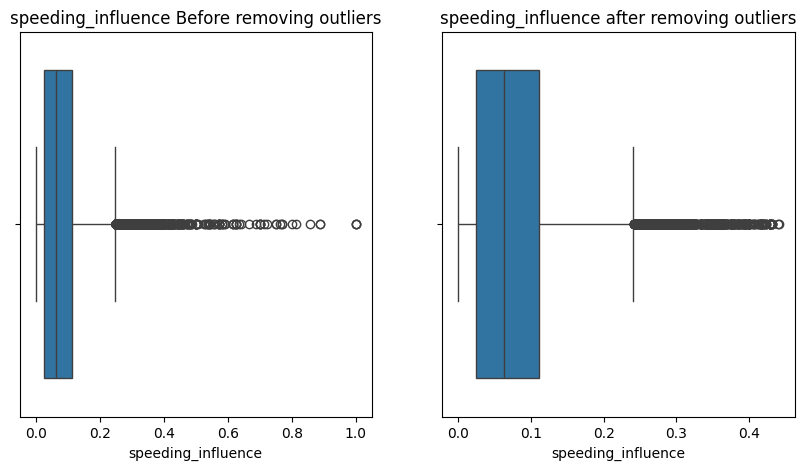

In [19]:
df_cleaned = df.drop(outliers.index)
feature = 'speeding_influence'
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df[feature])
plt.title(f'{feature} Before removing outliers')
plt.subplot(1, 2, 2)
sns.boxplot(x=df_cleaned[feature])
plt.title(f'{feature} after removing outliers')
plt.show()

In [20]:
outliers_count.drop_duplicates()
df_cleaned = df.drop(outliers_count.index)
df_cleaned.shape

(21696, 53)

In [21]:
df.shape

(22516, 53)

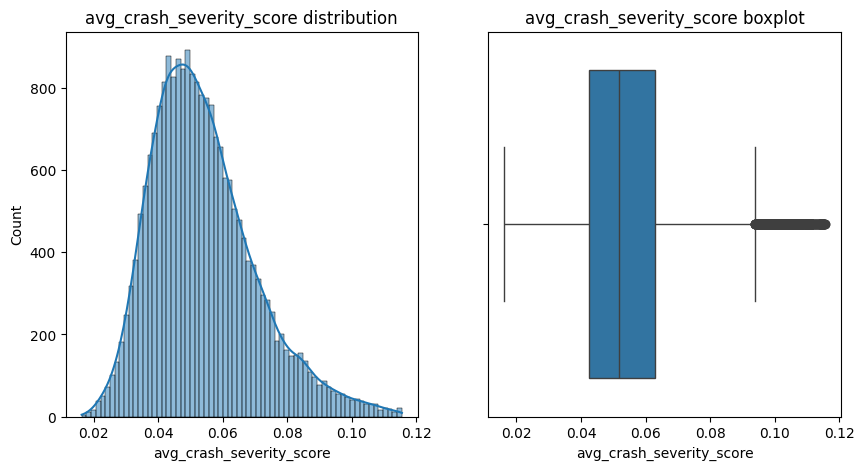

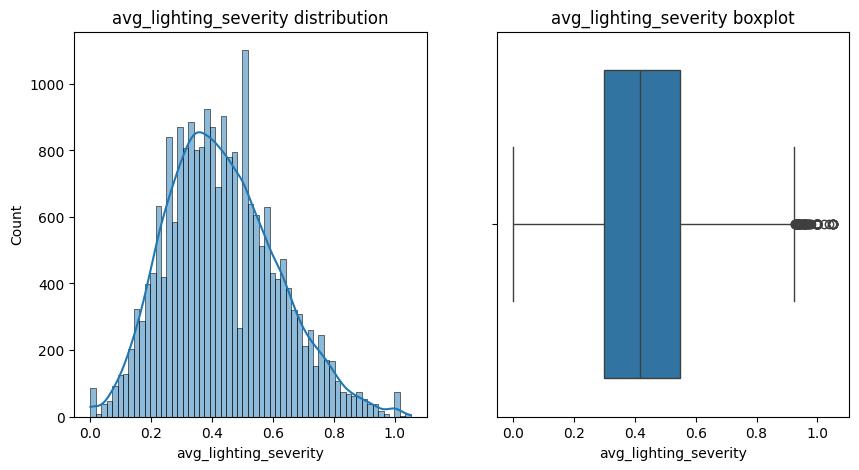

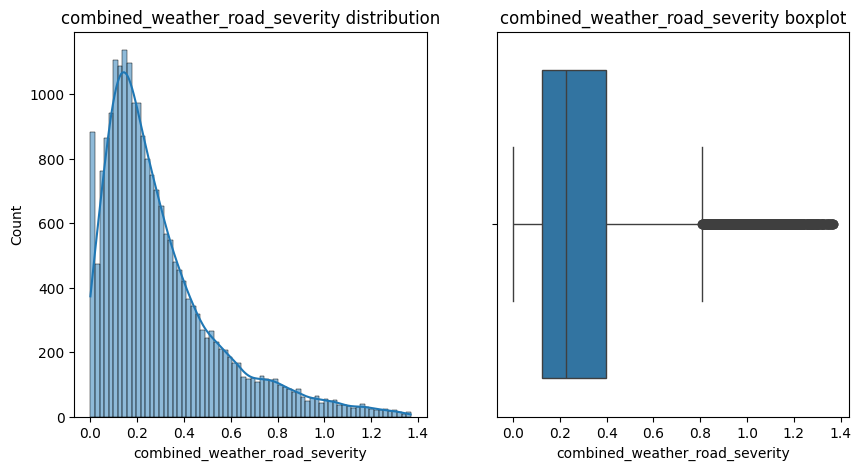

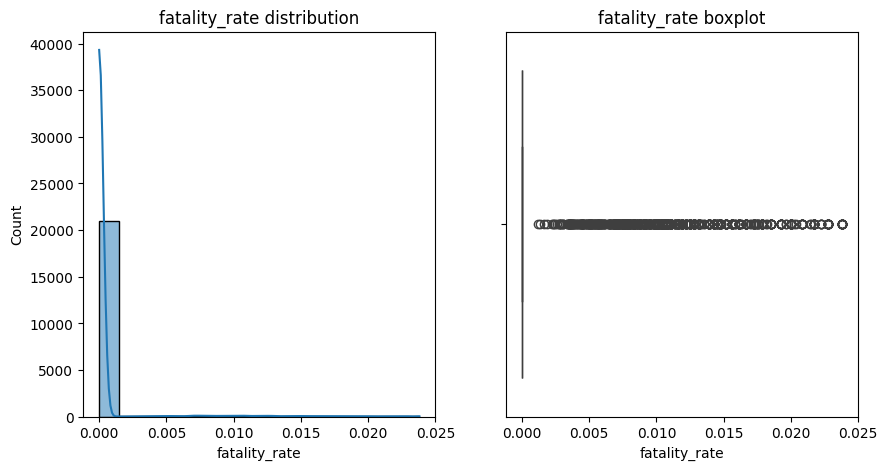

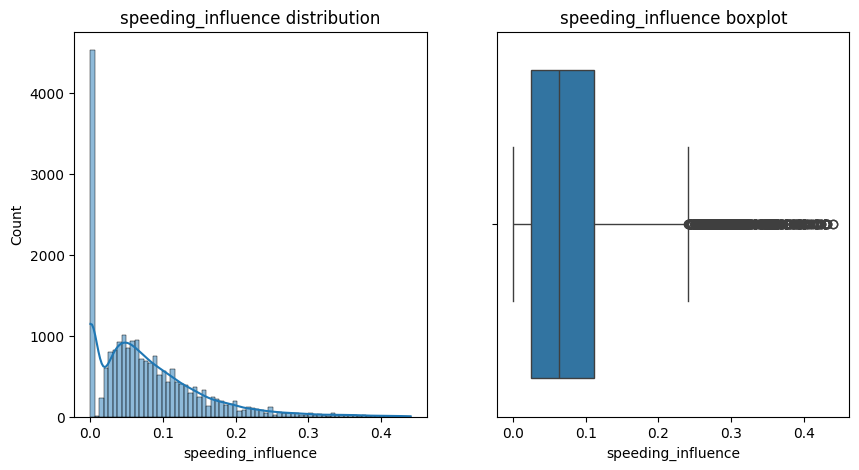

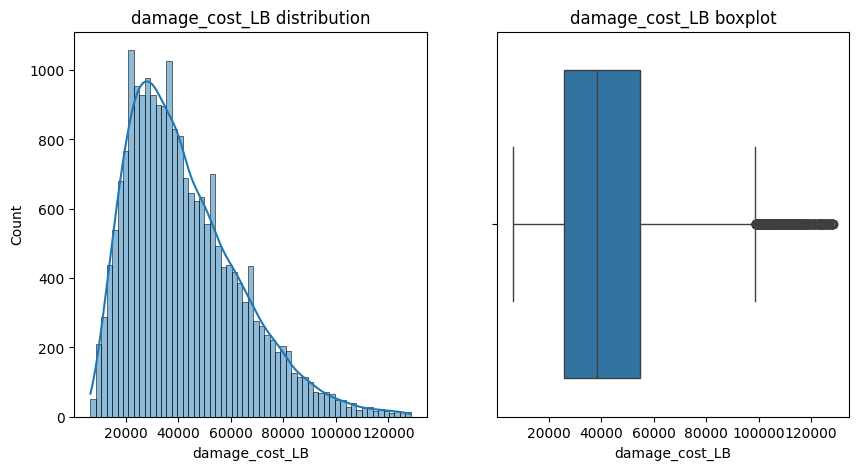

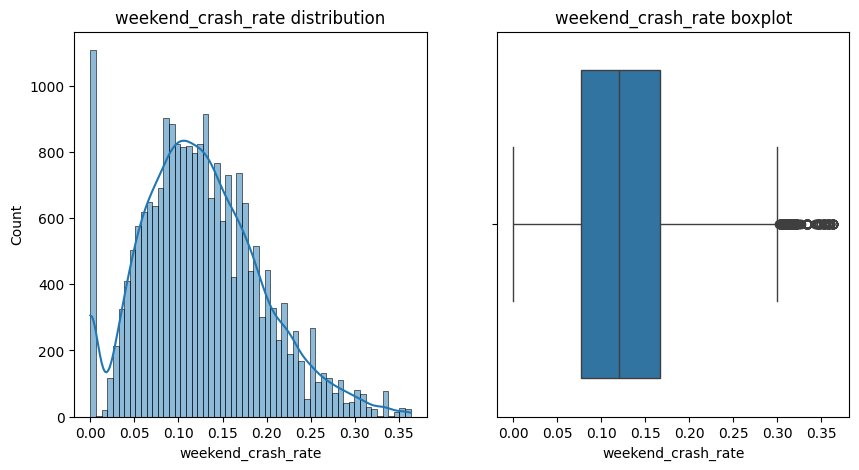

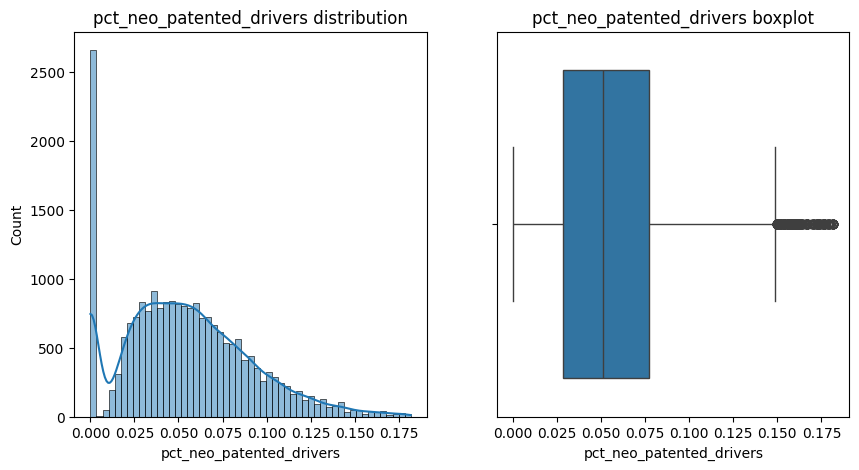

In [22]:
for feature in selected_features:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df_cleaned[feature], kde=True)
    plt.title(f'{feature} distribution')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_cleaned[feature])
    plt.title(f'{feature} boxplot')
    plt.show()

In [23]:
#save the cleaned dataset
df_cleaned.to_csv('dataset/incident_profile_95_cleaned.csv', index=False)